## Import packages.

In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

#rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 23
rcParams['font.weight'] = 300


## Download DR16 spectra.

> Download in parallel.

In [ ]:
import os

# open batch script
f = open("ys_run.sh", 'w')

# initiate text
file_text = ""

# loop over different batches
for c1 in range(26):
    file_text += "sbatch run_script_" + str(c1) + ".slurm\n"
    os.system("sed 's/XX/" + str(c1) + "/g' run_script_helios.slurm > run_script_" + str(c1) + ".slurm")
f.write(file_text)
f.close()
        

> Check which spectra were not downloaded.

In [ ]:
import numpy as np
import os
import astropy.io.fits as pyfits

#--------------------------------------------------------------------------------------
# list all the files
list_files = os.listdir("../apogee_dr16")
print(len(list_files))

# load catalog
catalog = pyfits.getdata("../allStar-r12-l33.fits")
catalog_id = catalog['APOGEE_ID'].astype("str")
print(catalog_id.shape)
print(np.unique(catalog_id).shape)

#--------------------------------------------------------------------------------------
# not downloaded
ind_missing = []

# loop over all spectra
for i in range(catalog_id.size):
    
    # monitor progress
    if i % 1000 == 0:
        print(i)
        
    # check 
    apogee_id = catalog_id[i]
    filename = 'apStar-r12-%s.fits' % apogee_id.strip() 
    if not(filename in list_files):
        ind_missing.append(i)
        
# convert into numpy
ind_missing = np.array(ind_missing)


In [ ]:
print(ind_missing.shape)
np.savez("ind_missing.npz", ind_missing=ind_missing)

> Inspect network architecture.

In [48]:
# define container
class model(torch.nn.Module):
    def __init__(self, num_neurons, num_features, mask_size):
        super(model, self).__init__()
        self.deconv1 = torch.nn.Conv1d(1, 8, mask_size, stride=3)
        self.deconv2 = torch.nn.Conv1d(8, 8, mask_size, stride=3)
        self.deconv3 = torch.nn.Conv1d(8, 8, mask_size, stride=3)
        self.deconv4 = torch.nn.Conv1d(8, 1, mask_size, stride=3)
        
        self.batch_norm1 = torch.nn.Sequential(
                            torch.nn.BatchNorm1d(8),
                            torch.nn.LeakyReLU()
        )
        self.batch_norm2 = torch.nn.Sequential(
                            torch.nn.BatchNorm1d(8),
                            torch.nn.LeakyReLU()
        )
        self.batch_norm3 = torch.nn.Sequential(
                            torch.nn.BatchNorm1d(8),
                            torch.nn.LeakyReLU()
        )
        self.batch_norm4 = torch.nn.Sequential(
                            torch.nn.BatchNorm1d(1),
                            torch.nn.LeakyReLU()
        )
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(85, num_neurons),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_neurons, num_neurons),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_neurons, num_features),
        )
    
    def forward(self, x):
        x = self.deconv1(x)
        x = self.batch_norm1(x)
        x = self.deconv2(x)
        x = self.batch_norm2(x)
        x = self.deconv3(x)
        x = self.batch_norm3(x)
        x = self.deconv4(x)
        x = self.batch_norm4(x)[:,0,:]
        x = self.mlp(x)
        return x
    
#-----------------------------------------------------------------------------------
# initiate model
model_conv = model(num_neurons=30, num_features=1, mask_size=11)

# forward model
spectra = np.zeros((100,7214))
spectra = torch.Tensor(spectra)
spectra = spectra[:,None,:]
y = model_conv(spectra)
print(y.shape)

torch.Size([100, 1])


## Infer stellar ages with MDN.

> Plot inferences.

(501, 1)
0.1358116


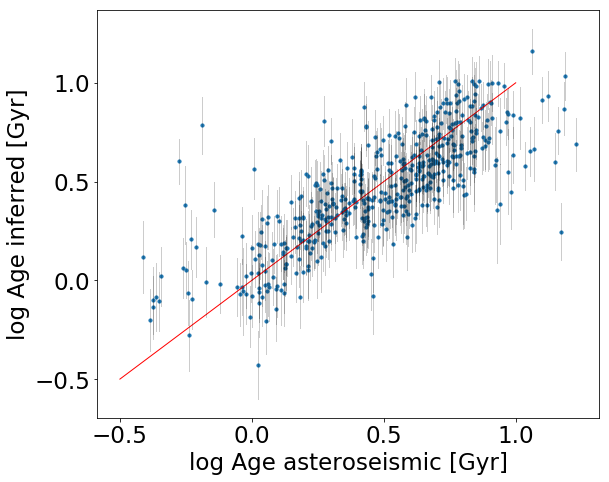

In [7]:
# load models
model = torch.load("../models.pt",  map_location=lambda storage, loc: storage) # load in cpu
model.eval()


#==============================================================================
# restore validation set
temp = np.load("../source_apogee_rc_spectra.npz")
apogee_spectra = temp["apogee_spectra"].T
apogee_spectra_err = temp["apogee_spectra_err"].T
apogee_spectra_all = temp["apogee_spectra_all"].T
apogee_log_age = temp["log_age"]
apogee_id = temp["apogee_id"]
apogee_payne_teff = temp["teff"]


#==============================================================================
# extract input and output arrays
input_array = np.copy(apogee_spectra).T
output_array = np.vstack([apogee_log_age]).T
all_array = np.copy(apogee_spectra_all).T

x = input_array[:2000,:]
y = output_array[:2000,:]
y_train = np.copy(y)

x_valid = input_array[2000:,:]
y_valid = output_array[2000:,:]
x_valid_count = x_valid.shape[0]

x_all = np.copy(all_array)


#==============================================================================
# scale the labels
x = x-0.
x_valid = x_valid-0. # convert to the write float format

y = y-0.
y_valid = y_valid-0.

#-----------------------------------------------------------------------------
# make pytorch variables
x = torch.Tensor(x)
y = torch.Tensor(y)

x_valid = torch.Tensor(x_valid)
y_valid = torch.Tensor(y_valid)


#==============================================================================
# plot inference
y_truth = y_valid.numpy() -3.
y_category, y_normal = model(x_valid)

# extract parameters
y_category = np.exp(y_category._param.detach().numpy())
print(y_category.shape)
y_normal_loc = y_normal.mean.detach().numpy()[:,:,0] -3.
y_normal_std = y_normal.stddev.detach().numpy()[:,:,0]

# the dominant mode
y_category_mode = np.argmax(y_category, axis=1)
y_pred = np.array([y_normal_loc[i,y_category_mode[i]] \
                   for i in range(y_normal_loc.shape[0])])
y_error = np.array([y_normal_std[i,y_category_mode[i]] \
                   for i in range(y_normal_std.shape[0])])

#-----------------------------------------------------------------------------
# plot results
y_truth = y_truth[:,0]
plt.scatter(y_truth, y_pred, s=10)
plt.plot([-0.5,1.0], [-0.5,1.0], color="red")

# plot error bar
for i in range(y_error.size):
    plt.plot([y_truth[i],y_truth[i]],[y_pred[i]-y_error[i],y_pred[i]+y_error[i]],\
             color='k', alpha=0.2)
plt.xlabel('log Age asteroseismic [Gyr]')
plt.ylabel('log Age inferred [Gyr]')

# print 1 sigma spread
print(np.median(y_error))


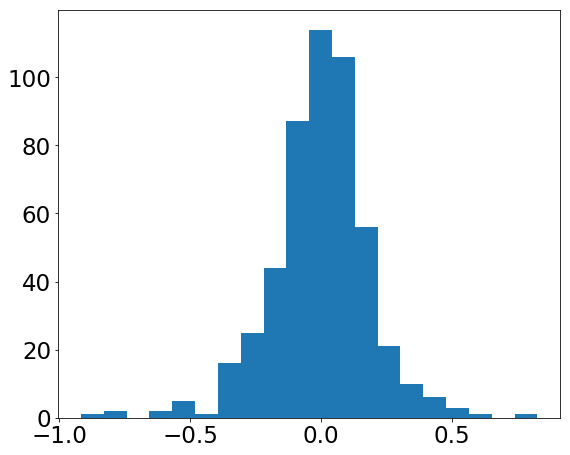

In [44]:
plt.hist(y_truth-y_pred, bins=20);

> Plot PDF.

In [ ]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  # x = np.linspace(-10.5, 10.5, 250)
  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i))
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)
  return final